In [21]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray
import rasterstats
from helpers.utils import kelvin_to_celcius


In [22]:
us_states_counties_filepath = "./data/gadm41_USA_2.json"
gdf_us_states_counties = gpd.read_file(filename=us_states_counties_filepath)
gdf_us_states_counties.head(10)


,GID_2,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry
0,USA.1.1_1,USA,UnitedStates,USA.1_1,Alabama,NA,Autauga,NA,NA,County,County,NA,US.AL.AU,"MULTIPOLYGON (((-86.91670 32.66430, -86.82680 ..."
1,USA.1.2_1,USA,UnitedStates,USA.1_1,Alabama,NA,Baldwin,NA,NA,County,County,NA,US.AL.BD,"MULTIPOLYGON (((-87.74420 30.29440, -87.74030 ..."
2,USA.1.3_1,USA,UnitedStates,USA.1_1,Alabama,NA,Barbour,NA,NA,County,County,NA,US.AL.BR,"MULTIPOLYGON (((-85.41610 31.61960, -85.49130 ..."
3,USA.1.4_1,USA,UnitedStates,USA.1_1,Alabama,NA,Bibb,NA,NA,County,County,NA,US.AL.BI,"MULTIPOLYGON (((-87.42080 32.87450, -87.42030 ..."
4,USA.1.5_1,USA,UnitedStates,USA.1_1,Alabama,NA,Blount,NA,NA,County,County,NA,US.AL.BU,"MULTIPOLYGON (((-86.96290 33.85860, -86.96510 ..."
5,USA.1.6_1,USA,UnitedStates,USA.1_1,Alabama,NA,Bullock,NA,NA,County,County,NA,US.AL.BL,"MULTIPOLYGON (((-85.41000 32.14680, -85.40960 ..."
6,USA.1.7_1,USA,UnitedStates,USA.1_1,Alabama,NA,Butler,NA,NA,County,County,NA,US.AL.BT,"MULTIPOLYGON (((-86.70190 31.52520, -86.83880 ..."
7,USA.1.8_1,USA,UnitedStates,USA.1_1,Alabama,NA,Calhoun,NA,NA,County,County,NA,US.AL.CN,"MULTIPOLYGON (((-85.73850 33.96880, -85.52930 ..."
8,USA.1.9_1,USA,UnitedStates,USA.1_1,Alabama,NA,Chambers,NA,NA,County,County,NA,US.AL.CM,"MULTIPOLYGON (((-85.13910 32.74630, -85.28510 ..."
9,USA.1.10_1,USA,UnitedStates,USA.1_1,Alabama,NA,Cherokee,NA,NA,County,County,NA,US.AL.CH,"MULTIPOLYGON (((-85.53010 33.94180, -85.52930 ..."


In [23]:
# get BBOX bounds from geospatial Dataframe
xmin, ymin, xmax, ymax = gdf_us_states_counties.total_bounds
xmin, ymin, xmax, ymax


(-179.1506, 18.9099, 179.7734, 72.687)

In [24]:
cds_dataset_filepath = './data/adaptor.mars.internal-1680355540.0991044-5320-7-52bf7b7c-5a85-4d56-bf57-d89cff49e132.nc'
cds_dataset = xr.open_dataset(filename_or_obj=cds_dataset_filepath)
cds_dataset

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 2880)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2022-01-01 ... 2022-12-10T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-04-01 13:27:32 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [25]:
latitiude = cds_dataset['latitude'].values
longitude = cds_dataset['longitude'].values
t2m = cds_dataset['t2m'].isel(time=0).values

In [58]:
affine_ds = cds_dataset.rio.transform()
affine_ds

Affine(0.25, 0.0, -0.125,
       0.0, -0.25, 90.125)

In [59]:
kelvin_values = np.apply_along_axis(kelvin_to_celcius, axis=1, arr=cds_dataset['t2m'].isel(time=0).values)
kelvin_values

array([[-24.710999, -24.710999, -24.710999, ..., -24.710999, -24.710999,
        -24.710999],
       [-24.146027, -24.14804 , -24.152084, ..., -24.139969, -24.141998,
        -24.144012],
       [-23.641586, -23.645615, -23.649658, ..., -23.633514, -23.637543,
        -23.639572],
       ...,
       [-22.747711, -22.753769, -22.759827, ..., -22.725525, -22.733597,
        -22.741669],
       [-22.501541, -22.505585, -22.509613, ..., -22.491455, -22.495499,
        -22.499527],
       [-22.400665, -22.400665, -22.400665, ..., -22.400665, -22.400665,
        -22.400665]], dtype=float32)

In [ ]:
default_crs = 'EPSG:4326'

In [40]:
gdf_us_states_counties.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [50]:
stats = rasterstats.zonal_stats(gdf_us_states_counties['geometry'], kelvin_values, affine=affine_ds, nodata=np.nan)
stats

[{'count': 0, 'min': None, 'max': None, 'mean': None},
 {'count': 0, 'min': None, 'max': None, 'mean': None},
 {'count': 0, 'min': None, 'max': None, 'mean': None},
 {'count': 0, 'min': None, 'max': None, 'mean': None},
 {'count': 0, 'min': None, 'max': None, 'mean': None},
 {'count': 0, 'min': None, 'max': None, 'mean': None},
 {'count': 0, 'min': None, 'max': None, 'mean': None},
 {'count': 0, 'min': None, 'max': None, 'mean': None},
 {'count': 0, 'min': None, 'max': None, 'mean': None},
 {'count': 0, 'min': None, 'max': None, 'mean': None},
 {'count': 0, 'min': None, 'max': None, 'mean': None},
 {'count': 0, 'min': None, 'max': None, 'mean': None},
 {'count': 0, 'min': None, 'max': None, 'mean': None},
 {'count': 0, 'min': None, 'max': None, 'mean': None},
 {'count': 0, 'min': None, 'max': None, 'mean': None},
 {'count': 0, 'min': None, 'max': None, 'mean': None},
 {'count': 0, 'min': None, 'max': None, 'mean': None},
 {'count': 0, 'min': None, 'max': None, 'mean': None},
 {'count':

In [37]:
f = [x['mean'] for x in stats]
print(f)

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 4.060373942057292, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, No

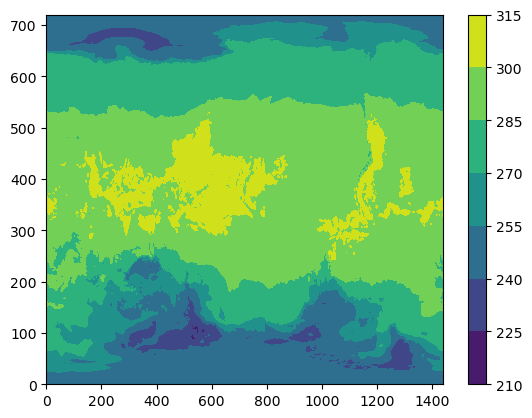

In [39]:
plt.contourf(cds_dataset['t2m'][0,:,:])
plt.colorbar()